### Surrogate model building for smoothly varying v(x,z) model

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd "/content/gdrive/My Drive/Colab Notebooks/Codes/PINN_isotropic_eikonal_R1"

In [ ]:
!pip install sciann==0.5.4.0
!pip install tensorflow==2.2.0
#!pip install keras==2.3.1 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io 
import time
import random

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [5]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [6]:
#Model specifications

v0 = 2; # Velocity at the origin (0,0)
vergrad = 0.4; # Vertical gradient
horgrad = 0.1; # Horizontal gradient

zmin = 0.; zmax = 6.; deltaz = 0.05;
xmin = 0.; xmax = 6.; deltax = 0.05;

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

Z,X = np.meshgrid(z,x,indexing='ij')

# Creating a mesh of sources
sz = np.array([0.1,2.1,4.0,5.9])
sx = np.array([0.1,2.1,4.0,5.9])

SZ,SX = np.meshgrid(sz,sx)

sz = SZ.reshape(-1,1)
sx = SX.reshape(-1,1)

# Velocity model for plotting
velmodel = v0 + vergrad*(Z-0.) + horgrad*(X-0.);


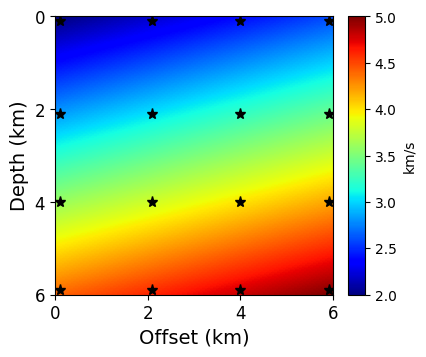

In [7]:
# Plot the velocity model
plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofxz_surrogate/sources.pdf", format='pdf', bbox_inches="tight")

In [8]:
# Preparing necessary arrays for the sources

X_star, Z_star, SX_star, SZ_star, T0_star, px0_star, pz0_star, tau_star, V_star = [[] for i in range(9)]


for ns, (szi, sxi) in enumerate(zip(sz, sx)):

    vs = v0 + vergrad*szi + + horgrad*sxi # Velocity at source point
    velmodel = vs + vergrad*(Z-szi) + horgrad*(X-sxi);

    T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sxi)**2 + (Z-szi)**2))/np.sqrt(vergrad**2 + horgrad**2)

    T0 = np.sqrt((Z-szi)**2 + (X-sxi)**2)/vs; 
    px0 = np.divide(X-sxi, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
    pz0 = np.divide(Z-szi, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

    tau_data = np.divide(T_data, T0, out=np.ones_like(T0), where=T0!=0)

    X_star.append(X.reshape(-1, 1))
    Z_star.append(Z.reshape(-1, 1))
    SX_star.append(np.ones_like(X.reshape(-1, 1)).reshape(-1,1)*sxi)
    SZ_star.append(np.ones_like(X.reshape(-1, 1)).reshape(-1,1)*szi)
    T0_star.append(T0.reshape(-1,1))
    px0_star.append(px0.reshape(-1,1))
    pz0_star.append(pz0.reshape(-1,1))
    tau_star.append(tau_data.reshape(-1,1))
    V_star.append(velmodel.reshape(-1,1))


X_star = np.concatenate(X_star, axis=0)
Z_star = np.concatenate(Z_star, axis=0)
SX_star = np.concatenate(SX_star, axis=0)
SZ_star = np.concatenate(SZ_star, axis=0)
tau_star = np.concatenate(tau_star, axis=0)
T0_star = np.concatenate(T0_star, axis=0)
px0_star = np.concatenate(px0_star, axis=0)
pz0_star = np.concatenate(pz0_star, axis=0)
V_star = np.concatenate(V_star, axis=0)

In [9]:
K.clear_session() 

layers = [20]*10

xt = Variable("xt",dtype='float64')
zt = Variable("zt",dtype='float64')
vt = Variable("vt",dtype='float64')
px0t = Variable("px0t",dtype='float64')
pz0t = Variable("pz0t",dtype='float64')
T0t = Variable("T0t",dtype='float64')
sxt = Variable("sxt",dtype='float64')
szt = Variable("szt",dtype='float64')

tau = Functional("tau", [xt, zt, sxt, szt], layers, 'l-atan')

L = (T0t*diff(tau, xt) + tau*px0t)**2 + (T0t*diff(tau, zt) + tau*pz0t)**2 - 1.0/vt**2


targets = [tau, PDE(20*L), (1-sign(tau))*abs(tau)]
target_vals = [tau_star, 'zeros', 'zeros']

model = SciModel(
    [xt, zt, pz0t, px0t, T0t, sxt, szt, vt], 
    targets
)

In [10]:
start_time = time.time()
hist = model.train(
    [X_star, Z_star, pz0_star, px0_star, T0_star, SX_star, SZ_star, V_star],
    target_vals, 
    batch_size=2000,
    epochs=65,
    verbose=0,
    learning_rate=0.0005
    )
elapsed = time.time() - start_time
print('Training time: %.2f seconds' %(elapsed))


Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Training time: 89.53 seconds


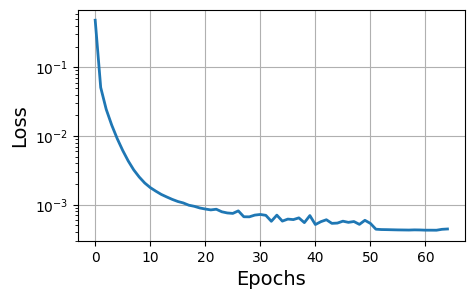

In [11]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(hist.history['loss'],LineWidth=2)

ax.set_xlabel('Epochs',fontsize=14)

plt.xticks(fontsize=10)
#ax.xaxis.set_major_locator(plt.MultipleLocator(500))

ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=10);
plt.grid()

In [12]:
# Selecting a source position for testing

np.random.seed(123)
sz = np.round(np.random.uniform(zmin,zmax),decimals=1)
sx = np.round(np.random.uniform(xmin,xmax),decimals=1)

print(sx)
print(sz)

1.7
4.2


In [13]:
vel = velmodel[int(round(sz/deltaz)),int(round(sx/deltax))] # Velocity at the source location

T0 = np.sqrt((Z-sz)**2 + (X-sx)**2)/vel; 

px0 = np.divide(X-sx, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-sz, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)

In [14]:
start_time = time.time()
tau_pred = tau.eval(model, [X, Z, px0, pz0, T0, np.ones_like(X)*sx, np.ones_like(X)*sz, velmodel])
elapsed = time.time() - start_time
print('Evaluation time: %.2f seconds' %(elapsed))

tau_pred = tau_pred.reshape(Z.shape)
T_pred = tau_pred*T0

Evaluation time: 0.09 seconds


In [15]:
vs = v0 + vergrad*sz + horgrad*sx
T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sx)**2 + (Z-sz)**2))/np.sqrt(vergrad**2 + horgrad**2)

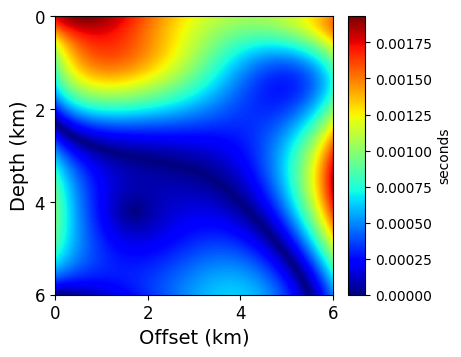

In [ ]:
# Plot the computed tau

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

#cbar.mappable.set_clim(0,0.0006)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofxz_surrogate/pinnerror.pdf", format='pdf', bbox_inches="tight")

In [16]:
# Load fast sweeping traveltims for comparison

T_fsm = np.load('./inputs/vofxz_surrogate/traveltimes/Tcomp.npy')

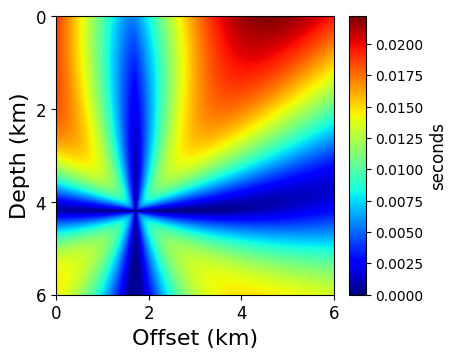

In [17]:
# Plot the computed tau

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fsm-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=16)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofxz_surrogate/fsmerror.pdf", format='pdf', bbox_inches="tight")

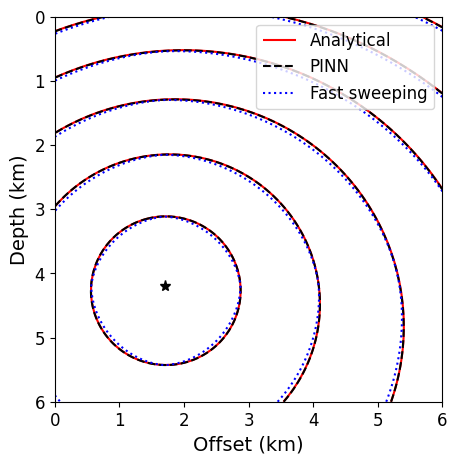

In [ ]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_pred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fsm, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', 'Fast sweeping'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("./figs/vofxz_surrogate/contours.pdf", format='pdf', bbox_inches="tight")